# Toronto Streetscore - CNN with Keras

In [1]:
import numpy as np 
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras.backend as K
from keras.models import Sequential

import lime
from lime import lime_image

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


Using TensorFlow backend.


In [2]:
# importing the Boston streetscore data for training
boston_df = pd.read_csv("boston/boston_image_with_target.csv")
boston_df.rename(columns = {'_file':'Image_Id'}, inplace = True)
boston_full = boston_df [["Image_Id", "safety"]]
boston_full.head()

,Image_Id,safety
0,gsv_0.jpg,1
1,gsv_1.jpg,1
2,gsv_2.jpg,1
3,gsv_3.jpg,1
4,gsv_4.jpg,1


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(boston_full, test_size=0.2)

In [4]:
train_df.safety.value_counts().head()

0    8728
1    7195
Name: safety, dtype: int64

In [5]:
test_df.safety.value_counts().head()

0    2093
1    1888
Name: safety, dtype: int64

In [6]:
# this will be used to preprocess the datasets
def prepareImages(data, m, dataset):
    print("Preparing images")
    X = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image_Id']:
        #load images into images of size 100x100x3
        img = image.load_img("boston/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X

In [7]:
# this will be used to generate labels for the training set
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)#

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [8]:
# This chunk of code was added to resolve the error "OSError: image file is truncated" in the below cell
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
# now the training data will be imported
X = prepareImages(train_df, train_df.shape[0], "image")
X /= 255

Preparing images
Processing image:  1 ,  gsv_8706.jpg
Processing image:  501 ,  gsv_17593.jpg
Processing image:  1001 ,  gsv_2923.jpg
Processing image:  1501 ,  gsv_9243.jpg
Processing image:  2001 ,  gsv_2498.jpg
Processing image:  2501 ,  gsv_18586.jpg
Processing image:  3001 ,  gsv_2763.jpg
Processing image:  3501 ,  gsv_5086.jpg
Processing image:  4001 ,  gsv_13387.jpg
Processing image:  4501 ,  gsv_12766.jpg
Processing image:  5001 ,  gsv_8059.jpg
Processing image:  5501 ,  gsv_1338.jpg
Processing image:  6001 ,  gsv_17760.jpg
Processing image:  6501 ,  gsv_19926.jpg
Processing image:  7001 ,  gsv_3610.jpg
Processing image:  7501 ,  gsv_17936.jpg
Processing image:  8001 ,  gsv_939.jpg
Processing image:  8501 ,  gsv_4749.jpg
Processing image:  9001 ,  gsv_18943.jpg
Processing image:  9501 ,  gsv_8286.jpg
Processing image:  10001 ,  gsv_15772.jpg
Processing image:  10501 ,  gsv_5362.jpg
Processing image:  11001 ,  gsv_4236.jpg
Processing image:  11501 ,  gsv_7196.jpg
Processing imag

In [10]:
y, label_encoder = prepare_labels(train_df['safety'])

/home/ndurai2006/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
# the CNN will now be defined
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], kernel_initializer='normal', activation='softmax', kernel_constraint=maxnorm(3), name='sm'))

# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activat

In [12]:
X.shape

(15923, 100, 100, 3)

In [13]:
y.shape

(15923, 2)

In [14]:
# this will train the CNN
history = model.fit(X, y, validation_split=0.2, epochs=75, batch_size=100, verbose=1)
gc.collect()

Instructions for updating:
Use tf.cast instead.
Train on 12738 samples, validate on 3185 samples
Epoch 1/75
12738/12738 [==============================] - 14s 1ms/step - loss: 0.7610 - acc: 0.5304 - val_loss: 0.6890 - val_acc: 0.5473
Epoch 2/75
12738/12738 [==============================] - 12s 957us/step - loss: 0.6895 - acc: 0.5489 - val_loss: 0.6892 - val_acc: 0.5473
Epoch 3/75
12738/12738 [==============================] - 12s 958us/step - loss: 0.6898 - acc: 0.5436 - val_loss: 0.6888 - val_acc: 0.5473
Epoch 4/75
12738/12738 [==============================] - 12s 955us/step - loss: 0.6902 - acc: 0.5430 - val_loss: 0.6916 - val_acc: 0.5473
Epoch 5/75
12738/12738 [==============================] - 12s 954us/step - loss: 0.6904 - acc: 0.5493 - val_loss: 0.6892 - val_acc: 0.5473
Epoch 6/75
12738/12738 [==============================] - 12s 955us/step - loss: 0.6898 - acc: 0.5451 - val_loss: 0.6842 - val_acc: 0.5548
Epoch 7/75
12738/12738 [==============================] - 12s 955us/ste

12738/12738 [==============================] - 12s 956us/step - loss: 0.4492 - acc: 0.7885 - val_loss: 0.6494 - val_acc: 0.6851
Epoch 58/75
12738/12738 [==============================] - 12s 954us/step - loss: 0.4463 - acc: 0.7909 - val_loss: 0.6761 - val_acc: 0.6678
Epoch 59/75
12738/12738 [==============================] - 12s 954us/step - loss: 0.4404 - acc: 0.7949 - val_loss: 0.6568 - val_acc: 0.6810
Epoch 60/75
12738/12738 [==============================] - 12s 954us/step - loss: 0.4345 - acc: 0.7965 - val_loss: 0.6752 - val_acc: 0.6797
Epoch 61/75
12738/12738 [==============================] - 12s 953us/step - loss: 0.4293 - acc: 0.8025 - val_loss: 0.6624 - val_acc: 0.6763
Epoch 62/75
12738/12738 [==============================] - 12s 955us/step - loss: 0.4255 - acc: 0.8037 - val_loss: 0.6776 - val_acc: 0.6659
Epoch 63/75
12738/12738 [==============================] - 12s 956us/step - loss: 0.4145 - acc: 0.8103 - val_loss: 0.6801 - val_acc: 0.6904
Epoch 64/75
12738/12738 [=======

97

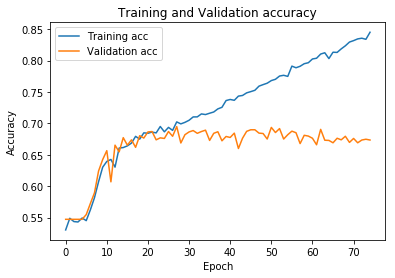

In [15]:
# This will plot the accuracy of the CNN on the training/validation set after each epoch
plt.plot(history.history['acc'], label='Training acc')
plt.plot(history.history['val_acc'], label='Validation acc')
plt.legend()
plt.title('Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

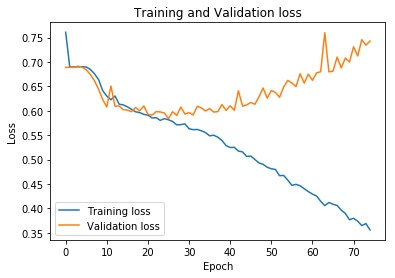

In [17]:
# This will plot the loss on the training and validation set after each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [19]:
# this will preprocess the test data
X = prepareImages(test_df, test_df.shape[0], "image")
X /= 255

Preparing images
Processing image:  1 ,  gsv_17915.jpg
Processing image:  501 ,  gsv_14555.jpg
Processing image:  1001 ,  gsv_19527.jpg
Processing image:  1501 ,  gsv_18622.jpg
Processing image:  2001 ,  gsv_3068.jpg
Processing image:  2501 ,  gsv_11012.jpg
Processing image:  3001 ,  gsv_6582.jpg
Processing image:  3501 ,  gsv_10743.jpg


In [20]:
y, label_encoder = prepare_labels(test_df['safety'])

/home/ndurai2006/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
# now the labels for the test data will be generated 
predictions = model.predict(np.array(X), verbose=1)

3981/3981 [==============================] - 2s 463us/step


In [19]:
# now the predictions will be saved in a csv file which can be submitted
# print(test_df.head(10))
# test_df.to_csv("data/submission_v5.csv", index=False)

In [22]:
%matplotlib inline
xs = X[100:110]
ys = y[100:110]

n_cols = 2
n_rows = int(len(xs)/2)
plt.figure(figsize=(3*n_cols, 3*n_rows))
for i in range(len(xs)):
    plt.subplot(5, 2, i+1)
    plt.imshow(xs[i].reshape(100,100,3), cmap='gray')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc9e80e0f28> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [23]:
# Persist the mode
model_yaml = model.to_yaml()
with open("model_keras_cnn_v3c.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_keras_cnn_v3c.h5")
print("Saved model to disk")
yaml_file.close()

Saved model to disk


In [24]:
from keras.models import Sequential, Model, load_model, model_from_yaml
# Load the model
yaml_file = open('model_keras_cnn_v3c.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_keras_cnn_v3c.h5")
print("Loaded model from disk")

Loaded model from disk


In [25]:
### Predictions on the selected input
input_x = X[100:110]
input_y = y[100:110]
sample_prediction = loaded_model.predict_classes(input_x)
print(sample_prediction)

[0 1 0 0 0 0 0 0 0 0]


In [26]:
explainer = lime_image.LimeImageExplainer()

In [46]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(input_x[0], model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.06 s, sys: 60 ms, total: 1.12 s
Wall time: 1.31 s


In [43]:
from skimage.segmentation import mark_boundaries

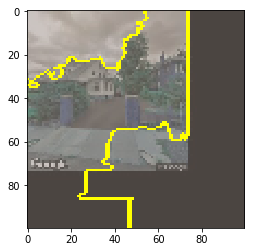

In [47]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

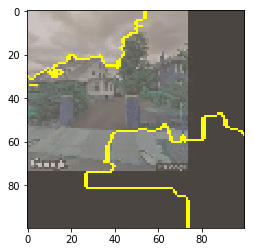

In [45]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))